<a href="https://colab.research.google.com/github/veselm73/sdueba-subgroup-discovery/blob/main/SDUEBA_Mushroom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -r https://raw.githubusercontent.com/veselm73/BP/main/requirements_SDUEBA010.txt --quiet
!wget -q -O SDUEBA_utils.py https://raw.githubusercontent.com/veselm73/BP/main/SDUEBA_utils.py --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━

In [1]:
# Dependencies
import os
import re
import string
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import scipy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.random_projection import GaussianRandomProjection
import hdbscan
import umap.umap_ as umap

import torch
from transformers import AutoTokenizer, AutoModel

from ucimlrepo import fetch_ucirepo
from gensim.models import Word2Vec

In [2]:
#SDUEBA Parameters:
"""
vector_space_dimension      ... dimension of the Word2Vec embedding space
descriptive_format          ... embedding creation parameter
embedding_method            ... embedding creation method "word2vec"/"bert"
weighted_embeddings         ... embedding creation parameter

clustering_method           ... clustering method #"agglomerative"/"spherical_kmeans"/"tspg"/"hdbscan"
use_bias                    ... decides between using supervised and unsupervised clustering "one_hot"/"perpendicular"
n_clusters                  ... number of clusters to be found
dendrogram_cut              ... dendrogram cut distance (only for agglomerative clustering)

max_depth                   ... maximal depth of the decision tree
test_size                   ... size of the test set for training the decision tree
tree_accuracy_threshold     ... minimal allowed accuracy for decision trees

target_column               ... target column
target_value                ... target value

description_lenght_limit    ... description length limit for for PIQ measure
difference_limit            ... difference limit for for PIQ measure
subgroup_size_limit         ... subgroup size limit for for PIQ measure
"""

#Embeddings parameters:
embedding_method = "word2vec"
vector_space_dimension = 50
descriptive_format = True
weighted_embeddings = False


#Clustering parameters:
clustering_method = "agglomerative"       #"agglomerative"/"spherical_kmeans"/"tspg_centroid"/"hdbscan"
n_clusters = 23
dendrogram_cut = None

use_bias = False
if use_bias:
    alpha_weight = 0.5
    bias_method = "one_hot"             #"one_hot"/"perpendicular"


#Decision tree parameters
max_depth = 2
test_size = 0.2
tree_accuracy_threshold = 0.95
target_column = 'edibility'
target_value = 'poisonous'


#Quality measure parameters
description_length_limit = 2
difference_limit = 0
subgroup_size_limit = 10

In [3]:
#Data augemntation

def preprocess_mushroom_data(df):

    mapping = {
    'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'},
    'cap-surface': {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'},
    'cap-color': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'bruises': {'t': 'bruises', 'f': 'no bruises'},
    'odor': {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'},
    'gill-attachment': {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'},
    'gill-spacing': {'c': 'close', 'w': 'crowded', 'd': 'distant'},
    'gill-size': {'b': 'broad', 'n': 'narrow'},
    'gill-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-shape': {'e': 'enlarging', 't': 'tapering'},
    'stalk-root': {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'},
    'stalk-surface-above-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-color-below-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'veil-type': {'p': 'partial', 'u': 'universal'},
    'veil-color': {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'},
    'ring-number': {'n': 'none', 'o': 'one', 't': 'two'},
    'ring-type': {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'},
    'spore-print-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'},
    'population': {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'},
    'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}
}

    for column, mapping in mapping.items():
        df[column] = df[column].replace(mapping)

    return df

mapping_targets = {'p': 'poisonous', 'e': 'edible'}

data = fetch_ucirepo(id=73)
features_raw = preprocess_mushroom_data(pd.DataFrame(data=data.data.features))
target_df = pd.DataFrame(data=data.data.targets).replace(mapping_targets)
target_df.rename(columns={'poisonous': 'edibility'}, inplace=True)

training_df = pd.merge(features_raw, target_df, left_index=True, right_index=True)

In [4]:
class WeightNormalizer:
    @staticmethod
    def normalize(weights):
        weights_array = np.array(weights)
        min_val = np.min(weights_array)
        max_val = np.max(weights_array)

        if max_val == min_val:
            return np.zeros_like(weights_array)

        return (weights_array - min_val) / (max_val - min_val)


class DataPreprocessor:
    def __init__(self, df, target_column):
        self.df = df.copy()
        self.target_column = target_column
        self.label_encoders = {}
        self.imputer = SimpleImputer(strategy="most_frequent")

    def encode_categorical(self):
        categorical_columns = self.df.select_dtypes(include=['object']).columns
        for col in categorical_columns:
            le = LabelEncoder()
            self.df[col] = le.fit_transform(self.df[col].astype(str))
            self.label_encoders[col] = le

    def impute(self):
        self.df = pd.DataFrame(self.imputer.fit_transform(self.df), columns=self.df.columns)

    def get_features_and_target(self):
        X = self.df.drop(columns=[self.target_column])
        y = self.df[self.target_column]
        return X, y

    def preprocess(self):
        self.encode_categorical()
        self.impute()
        return self.get_features_and_target()


class ModelTrainer:
    def __init__(self, model=None):
        self.model = model or RandomForestClassifier(n_estimators=100, random_state=73)

    def train(self, X, y):
        self.model.fit(X, y)

    def get_feature_weights(self, feature_names):
        return pd.DataFrame({
            'Feature': feature_names,
            'Weight': WeightNormalizer.normalize(self.model.feature_importances_)
            })

# df_preprocessor = DataPreprocessor(training_df, target_column)
# X, y = df_preprocessor.preprocess()
# trainer = ModelTrainer()
# trainer.train(X, y)
# feature_weights = trainer.get_feature_weights(X.columns)
# feature_weights = pd.concat([feature_weights, pd.DataFrame({'Feature': [target_column], 'Weight': [1]})], ignore_index=True)

In [5]:
class SentenceFormatter:
    def __init__(self, dataframe, descriptive_format=True):
        self.df = dataframe.copy()
        self.descriptive_format = descriptive_format

    def _prettify_column_names(self):
        return [' '.join(col.split('-')) for col in self.df.columns]

    def generate_sentences(self):
        sentences = []
        if self.descriptive_format:
            pretty_columns = self._prettify_column_names()
            for _, row in self.df.iterrows():
                sentence = [f"{col_name} is {val}" for col_name, val in zip(pretty_columns, row)]
                sentences.append(sentence)
        else:
            for _, row in self.df.iterrows():
                sentence = [str(val) for val in row]
                sentences.append(sentence)

        return sentences

formatter = SentenceFormatter(training_df, descriptive_format=descriptive_format)
sentences = formatter.generate_sentences()
print(sentences[0])

['cap shape is convex', 'cap surface is smooth', 'cap color is brown', 'bruises is bruises', 'odor is pungent', 'gill attachment is free', 'gill spacing is close', 'gill size is narrow', 'gill color is black', 'stalk shape is enlarging', 'stalk root is equal', 'stalk surface above ring is smooth', 'stalk surface below ring is s', 'stalk color above ring is w', 'stalk color below ring is white', 'veil type is partial', 'veil color is white', 'ring number is one', 'ring type is pendant', 'spore print color is black', 'population is scattered', 'habitat is urban', 'edibility is poisonous']


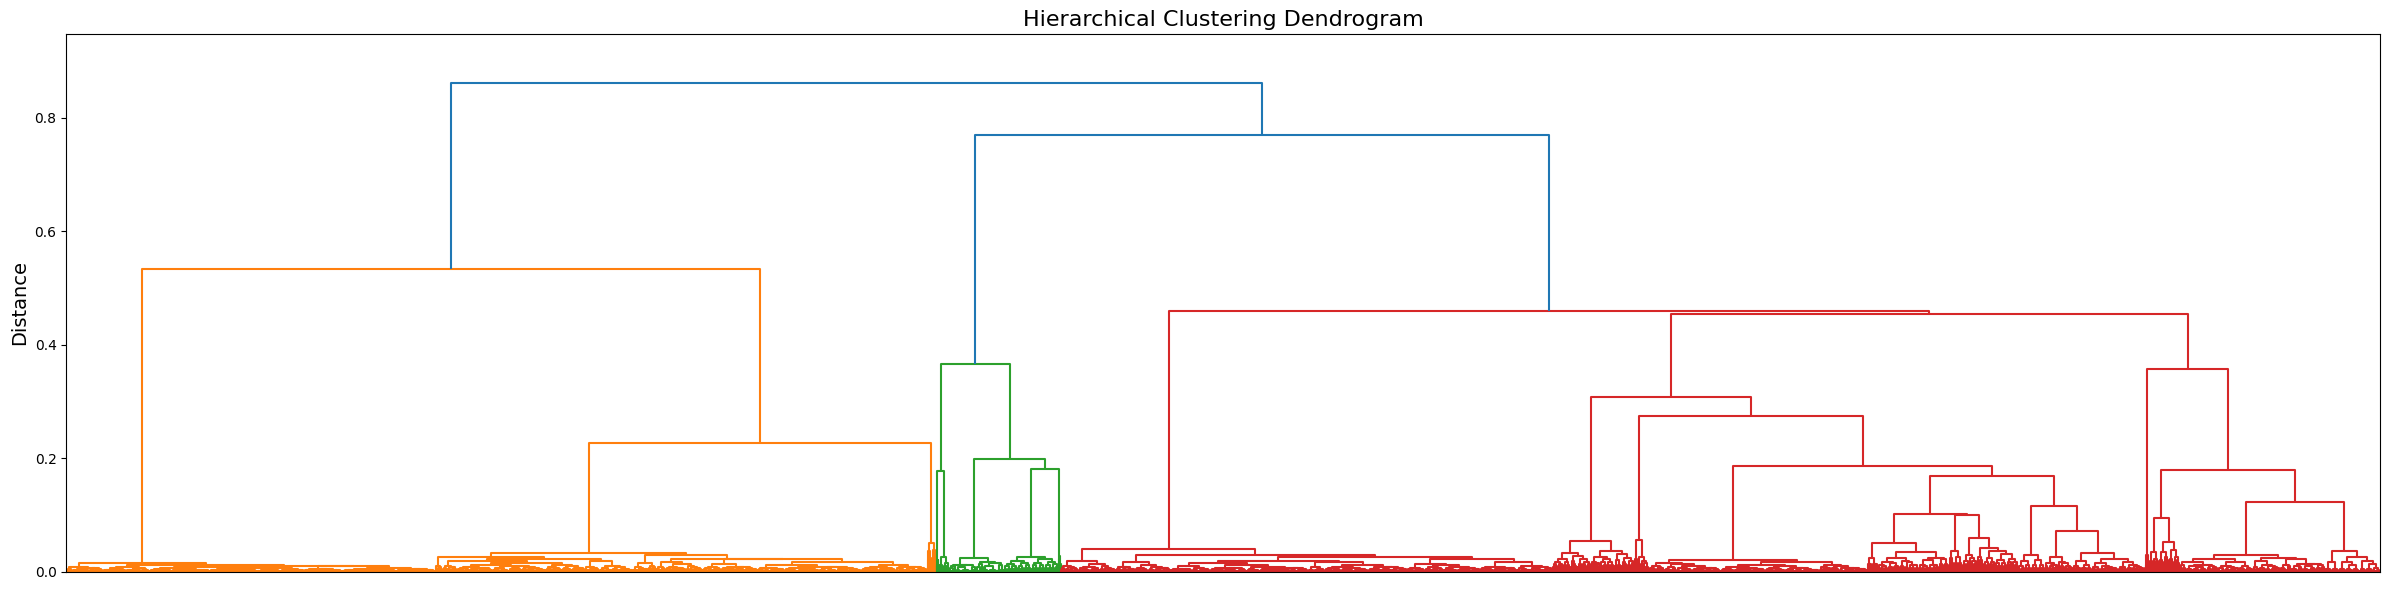

In [6]:
#Word2Vec/Bert training and clustering
def clear_cuda_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

class Word2VecModel:
    def __init__(self, sentences, vector_size=vector_space_dimension, window=15, min_count=1):
        self.model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count)

    def get_embedding(self, sentence, weighted_embeddings=False, feature_weights=None):
        word_embeddings = [self.model.wv[word] for word in sentence if word in self.model.wv]
        if not word_embeddings:
            return np.zeros(self.model.vector_size)

        if weighted_embeddings and feature_weights is not None:
            weights = np.array(feature_weights['Weight'].tolist())
            return np.average(word_embeddings, axis=0, weights=weights)
        return np.mean(word_embeddings, axis=0)

class BertEmbedder:
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2", device=None, batch_size=16):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device).half()
        self.batch_size = batch_size

    def get_embedding(self, sentences):
        if isinstance(sentences[0], list):
            sentences = [" ".join(sentence) for sentence in sentences]

        embeddings = []
        for i in range(0, len(sentences), self.batch_size):
            batch = sentences[i:i + self.batch_size]
            inputs = self.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=256).to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

        return np.vstack(embeddings)

class SentenceEmbedder:
    def __init__(self, method="word2vec", **kwargs):
        self.method = method.lower()

        if self.method == "word2vec":
            self.model = Word2VecModel(**kwargs)
        elif self.method == "bert":
            self.model = BertEmbedder(**kwargs)
        else:
            raise ValueError("Unsupported embedding method. Use 'word2vec' or 'bert'.")

    def generate_embeddings(self, sentences, normalize=False, weighted_embeddings=False, feature_weights=None):
        if self.method == "word2vec":
            embeddings = np.array([
                self.model.get_embedding(s, weighted_embeddings=weighted_embeddings, feature_weights=feature_weights)
                for s in sentences
            ])
        elif self.method == "bert":
            embeddings = self.model.get_embedding(sentences)
        else:
            raise ValueError("Unsupported embedding method.")

        if normalize:
            norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
            norms[norms == 0] = 1  # Avoid division by zero
            embeddings = embeddings / norms

        return embeddings

class BiasedEmbedder:
    def __init__(self, alpha=0.1, random_state=73, bias_method="one_hot", use_bias=True):
        self.use_bias = use_bias
        self.alpha = alpha
        self.random_state = random_state
        self.bias_method = bias_method.lower() if bias_method is not None else None

        if self.use_bias:
            self._validate_bias_method()

    def _validate_bias_method(self):
        if self.bias_method is None:
            return
        elif self.bias_method not in ["one_hot", "perpendicular"]:
            raise ValueError(f"Unsupported bias method: {self.bias_method}. Choose 'one_hot', 'perpendicular', or None.")

    def apply_bias(self, embeddings, targets):
        if not self.use_bias or self.bias_method is None:
            return embeddings

        if self.bias_method == "one_hot":
            return self._one_hot_bias_embeddings(embeddings, targets)
        elif self.bias_method == "perpendicular":
            return self._perpendicular_bias_embeddings(embeddings, targets)

    def _perpendicular_bias_embeddings(self, embeddings, targets):
        embeddings_biased = np.copy(embeddings)
        unique_classes, targets_encoded = np.unique(targets, return_inverse=True)
        np.random.seed(self.random_state)

        if len(unique_classes) > embeddings.shape[1]:
            raise ValueError("Number of unique classes exceeds embedding dimension, cannot create perpendicular biases.")

        bias_vectors = np.eye(len(unique_classes), embeddings.shape[1])

        for i, class_idx in enumerate(targets_encoded):
            embeddings_biased[i] += self.alpha * bias_vectors[class_idx]

        return embeddings_biased

    def _one_hot_bias_embeddings(self, embeddings, targets):
        unique_classes, targets_encoded = np.unique(targets, return_inverse=True)

        embeddings_extended = np.zeros((embeddings.shape[0], embeddings.shape[1] + len(unique_classes)))
        embeddings_extended[:, :embeddings.shape[1]] = embeddings

        for i, class_idx in enumerate(targets_encoded):
            embeddings_extended[i, embeddings.shape[1] + class_idx] = self.alpha

        return embeddings_extended

class ClusteringModel:
    def __init__(self, n_clusters=None, method="agglomerative", random_state=73,
                 dendrogram_cut=None, hdbscan_min_cluster_size=None):
        self.n_clusters = n_clusters
        self.method = method
        self.random_state = random_state
        self.dendrogram_cut = dendrogram_cut
        self.hdbscan_min_cluster_size = hdbscan_min_cluster_size
        self.linkage_matrix = None

    def fit_predict(self, embeddings, **method_params):
        clustering_methods = {
            "spherical_kmeans": self._spherical_kmeans_clustering,
            "agglomerative": self._agglomerative_clustering,
            "tspg": self._tspg_clustering,
            "tspg_centroid": self._tspg_centroid_clustering,
            "hdbscan": self._hdbscan_clustering
        }

        if self.method in clustering_methods:
            return clustering_methods[self.method](embeddings, **method_params)

        raise ValueError(f"Unsupported clustering method: {self.method}")

    def _spherical_kmeans_clustering(self, X, **kwargs):
        np.random.seed(self.random_state)
        X = normalize(X, norm='l2', axis=1)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        cluster_centers = X[indices]

        for _ in range(200):
            similarities = X @ cluster_centers.T
            labels = np.argmax(similarities, axis=1)
            new_centroids = np.array([
                normalize(X[labels == j].mean(axis=0).reshape(1, -1))
                if np.any(labels == j) else cluster_centers[j]
                for j in range(self.n_clusters)
            ]).squeeze()

            if np.linalg.norm(new_centroids - cluster_centers) < 1e-4:
                break
            cluster_centers = new_centroids

        return labels

    def _tspg_clustering(self, X, num_paths=2, window=5, metric='cosine', normalize_input=True, depth=4, min_size=500):
        X = np.array(X, dtype=np.float32)
        n_clusters = self.n_clusters
        random_state = self.random_state

        if n_clusters is None:
            raise ValueError("n_clusters must be specified for TSPG clustering.")

        if normalize_input and metric == 'cosine':
            X = normalize(X, norm='l2')

        n = X.shape[0]
        rng = np.random.RandomState(random_state)
        edge_set = set()

        for _ in range(num_paths):
            def recurse(indices, current_depth):
                if len(indices) <= min_size or current_depth >= depth:
                    projection = GaussianRandomProjection(n_components=1, random_state=rng.randint(0, 1e9))
                    X_proj = projection.fit_transform(X[indices]).flatten()
                    sorted_idx = indices[np.argsort(X_proj)]
                    for i in range(len(sorted_idx)):
                        for j in range(1, min(window + 1, len(sorted_idx) - i)):
                            a, b = sorted_idx[i], sorted_idx[i + j]
                            edge_set.add((min(a, b), max(a, b)))
                    return
                projection = GaussianRandomProjection(n_components=1, random_state=rng.randint(0, 1e9))
                X_proj = projection.fit_transform(X[indices]).flatten()
                median = np.median(X_proj)
                left = indices[X_proj <= median]
                right = indices[X_proj > median]
                recurse(left, current_depth + 1)
                recurse(right, current_depth + 1)

            recurse(np.arange(n, dtype=np.uint32), 0)

        a_idx = np.fromiter((i for i, _ in edge_set), dtype=np.uint32)
        b_idx = np.fromiter((j for _, j in edge_set), dtype=np.uint32)

        if metric == 'cosine':
            sims = np.sum(X[a_idx] * X[b_idx], axis=1)
            dists = 1.0 - sims
        else:
            diffs = X[a_idx] - X[b_idx]
            dists = np.sqrt(np.sum(diffs**2, axis=1))

        edges = list(zip(dists, a_idx.tolist(), b_idx.tolist()))
        edges.sort()

        parent = np.arange(n, dtype=np.uint32)

        def find(i):
            while parent[i] != i:
                parent[i] = parent[parent[i]]
                i = parent[i]
            return i

        def union(i, j):
            pi, pj = find(i), find(j)
            if pi != pj:
                parent[pi] = pj
                return True
            return False

        num_components = n
        for d, i, j in edges:
            if union(i, j):
                num_components -= 1
                if num_components == n_clusters:
                    break

        label_map = {}
        labels = np.empty(n, dtype=np.uint32)
        next_label = 0
        for i in range(n):
            root = find(i)
            if root not in label_map:
                label_map[root] = next_label
                next_label += 1
            labels[i] = label_map[root]

        return labels

    def _tspg_centroid_clustering(self, X, num_paths=2, window=5, normalize_input=True, depth=4, min_size=500, knn_fallback_k=5):
        X = np.array(X, dtype=np.float32)
        n_clusters = self.n_clusters
        random_state = self.random_state

        if n_clusters is None:
            raise ValueError("n_clusters must be specified for TSPG centroid clustering.")

        if normalize_input:
            X = normalize(X, norm='l2')

        n = X.shape[0]
        rng = np.random.RandomState(random_state)
        edge_set = set()

        for _ in range(num_paths):
            def recurse(indices, current_depth):
                if len(indices) <= min_size or current_depth >= depth:
                    projection = GaussianRandomProjection(n_components=1, random_state=rng.randint(0, 1e9))
                    X_proj = projection.fit_transform(X[indices]).flatten()
                    sorted_idx = indices[np.argsort(X_proj)]
                    for i in range(len(sorted_idx)):
                        for j in range(1, min(window + 1, len(sorted_idx) - i)):
                            a, b = sorted_idx[i], sorted_idx[i + j]
                            edge_set.add((min(a, b), max(a, b)))
                    return
                projection = GaussianRandomProjection(n_components=1, random_state=rng.randint(0, 1e9))
                X_proj = projection.fit_transform(X[indices]).flatten()
                median = np.median(X_proj)
                left = indices[X_proj <= median]
                right = indices[X_proj > median]
                recurse(left, current_depth + 1)
                recurse(right, current_depth + 1)

            recurse(np.arange(n, dtype=np.uint32), 0)

        nn = NearestNeighbors(n_neighbors=knn_fallback_k + 1, metric='cosine')
        nn.fit(X)
        neighbors = nn.kneighbors(return_distance=False)
        for i in range(n):
            for j in neighbors[i][1:]:
                edge_set.add((min(i, j), max(i, j)))

        a_idx = np.fromiter((i for i, _ in edge_set), dtype=np.uint32)
        b_idx = np.fromiter((j for _, j in edge_set), dtype=np.uint32)
        sims = np.sum(X[a_idx] * X[b_idx], axis=1)
        dists = 1.0 - sims
        edges = list(zip(dists, a_idx.tolist(), b_idx.tolist()))
        edges.sort()

        labels = np.arange(n, dtype=np.int32)
        cluster_members = {i: [i] for i in range(n)}

        def compute_centroid(indices):
            vec = X[indices].mean(axis=0)
            norm = np.linalg.norm(vec)
            return vec / norm if norm > 0 else vec

        centroids = {i: X[i] for i in range(n)}

        current_cluster_id = n
        for d, i, j in edges:
            ci, cj = labels[i], labels[j]
            if ci == cj:
                continue

            members_i = cluster_members[ci]
            members_j = cluster_members[cj]
            merged_members = members_i + members_j

            new_centroid = compute_centroid(merged_members)

            for idx in merged_members:
                labels[idx] = current_cluster_id

            cluster_members[current_cluster_id] = merged_members
            centroids[current_cluster_id] = new_centroid

            del cluster_members[ci]
            del cluster_members[cj]
            del centroids[ci]
            del centroids[cj]

            current_cluster_id += 1

            if len(np.unique(labels)) <= n_clusters:
                break

        unique_labels = np.unique(labels)
        label_map = {old: new for new, old in enumerate(unique_labels)}
        final_labels = np.array([label_map[label] for label in labels], dtype=np.int32)

        return final_labels

    def _hdbscan_clustering(self, embeddings, **kwargs):
        distance_matrix = cosine_distances(embeddings).astype(np.float64)
        clusterer = hdbscan.HDBSCAN(min_cluster_size=self.hdbscan_min_cluster_size, metric='precomputed')
        labels = clusterer.fit_predict(distance_matrix)
        return labels

    def _agglomerative_clustering(self, embeddings, **kwargs):
        self.linkage_matrix = linkage(embeddings, method='average', metric='cosine')
        if self.dendrogram_cut:
            labels = fcluster(self.linkage_matrix, self.dendrogram_cut, criterion='distance') - 1
        elif self.n_clusters:
            labels = fcluster(self.linkage_matrix, self.n_clusters, criterion='maxclust') - 1
        else:
            labels = AgglomerativeClustering(n_clusters=self.n_clusters, metric='cosine', linkage='average').fit_predict(embeddings)
        return labels

    def plot_dendrogram(self, max_d=None, truncate_mode='level', p=30):
        if self.linkage_matrix is None:
            return

        plt.figure(figsize=(24, 6))
        dendrogram(self.linkage_matrix, truncate_mode=truncate_mode, p=p,
                   color_threshold=max_d, distance_sort='ascending', show_leaf_counts=True, no_labels=True)

        ylim = max_d * 1.1 if max_d else np.max(self.linkage_matrix[:, 2]) * 1.1
        plt.ylim(0, ylim)

        plt.title("Hierarchical Clustering Dendrogram", fontsize=16)
        plt.ylabel("Distance", fontsize=14)
        plt.tight_layout()
        plt.show()



if embedding_method == "word2vec":
    embedder = SentenceEmbedder(method="word2vec", sentences=sentences, vector_size=vector_space_dimension)
    sentence_embeddings = embedder.generate_embeddings(sentences, normalize=True)

elif embedding_method == "bert":
    embedder = SentenceEmbedder(method="bert", model_name="sentence-transformers/all-MiniLM-L6-v2")
    sentence_embeddings = embedder.generate_embeddings(sentences, normalize=True)

biased_embedder = BiasedEmbedder(use_bias=use_bias)
biased_embeddings = biased_embedder.apply_bias(embeddings=sentence_embeddings, targets=target_df[target_column])




clustering_model = ClusteringModel(n_clusters=n_clusters, method=clustering_method, random_state=73, dendrogram_cut=dendrogram_cut, hdbscan_min_cluster_size=subgroup_size_limit)
labels = clustering_model.fit_predict(biased_embeddings, num_paths=7, window=15, normalize_input=True, min_size=50, depth=7, knn_fallback_k=5)

clustering_model.plot_dendrogram()

In [7]:
class DecisionTreeTrainer:
    def __init__(self, features_raw, labels, max_depth, subgroup_size_limit, test_size, random_state=73, print_acc=True):
        self.features_raw = features_raw
        self.labels = labels
        self.max_depth = max_depth
        self.subgroup_size_limit = subgroup_size_limit
        self.test_size = test_size
        self.random_state = random_state
        self.print_acc = print_acc

        self.encoder = OneHotEncoder()
        self.decision_trees = {}
        self.accuracies = {}
        self.small_clusters = {}

        self._prepare_data()
        self._train_trees()

    def _prepare_data(self):
        features_classify = self.features_raw.assign(cluster=self.labels)

        cluster_counts = features_classify['cluster'].value_counts()

        small_cluster_labels = cluster_counts[cluster_counts < self.subgroup_size_limit].index
        self.small_clusters = {
            label: features_classify[features_classify['cluster'] == label]
            for label in small_cluster_labels
        }

        features_classify = features_classify[~features_classify['cluster'].isin(small_cluster_labels)]

        X = features_classify.drop(columns=['cluster'])
        X_encoded = self.encoder.fit_transform(X)
        y = features_classify['cluster']

        self.X_df = pd.DataFrame(X_encoded.toarray(), columns=self.encoder.get_feature_names_out())

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_df, y, test_size=self.test_size, random_state=self.random_state, stratify=y)


    def _train_trees(self):
        for cluster in sorted(self.y_train.unique()):
            y_train_binary = (self.y_train == cluster).astype(int)
            y_test_binary = (self.y_test == cluster).astype(int)

            clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.subgroup_size_limit, random_state=self.random_state)
            clf.fit(self.X_train, y_train_binary)

            self.decision_trees[cluster] = clf

            y_pred = clf.predict(self.X_test)
            accuracy = accuracy_score(y_test_binary, y_pred)
            self.accuracies[cluster] = accuracy

            if self.print_acc:
                print(f"Accuracy for Cluster {cluster}: {accuracy:.4f}")
                print(classification_report(y_test_binary, y_pred))

    def get_trees(self):
        return self.decision_trees

    def get_accuracies(self):
        return self.accuracies

    def plot_decision_trees(self, cluster_index=None):
        if cluster_index is not None:
            if cluster_index in self.decision_trees:
                plt.figure(figsize=(12, 8))
                plot_tree(self.decision_trees[cluster_index], feature_names=self.X_df.columns, filled=True, rounded=True)
                plt.title(f"Decision Tree for Cluster {cluster_index}")
                plt.show()
            else:
                print(f"Cluster {cluster_index} not found.")
        else:
            for cluster, tree in self.decision_trees.items():
                plt.figure(figsize=(12, 8))
                plot_tree(tree, feature_names=self.X_df.columns, filled=True, rounded=True)
                plt.title(f"Decision Tree for Cluster {cluster}")
                plt.show()


tree_trainer = DecisionTreeTrainer(
    features_raw=features_raw,
    labels=labels,
    max_depth=max_depth,
    subgroup_size_limit=subgroup_size_limit,
    test_size=test_size,
    print_acc=False
)

In [8]:
# Subgroup creation and quality evaluation
def Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit):
    difference = abs(tp / (tp + fp) - (TP / (TP + FP)))
    if difference < difference_limit or description_length > description_length_limit or (tp + fp) < subgroup_size_limit:
        return np.NaN
    return difference / description_length

class ClusterRuleExtractor:
    def __init__(self, data_frame, target_df, cluster_labels, feature_names, decision_trees, trees_acc, tree_accuracy_threshold, small_clusters=None):
        self.data_frame = data_frame
        self.target_df = target_df
        self.cluster_labels = cluster_labels
        self.feature_names = feature_names
        self.decision_trees = decision_trees
        self.trees_acc = trees_acc
        self.tree_accuracy_threshold = tree_accuracy_threshold
        self.small_clusters = small_clusters if small_clusters is not None else {}

        self.target_column = target_df.columns[0]

        self.cluster_frequencies = {}
        self.cluster_percentages = {}
        self.rules_dict = {}
        self.unextractable_clusters = []
        self.WRAcc_dict = {}

        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}

        self._extract_rules_for_clusters()

    def _extract_rules_from_tree(self, tree, node=0, path=None, rule_dict=None):
        if path is None:
            path = []
        if rule_dict is None:
            rule_dict = defaultdict(list)

        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        threshold = tree.tree_.threshold[node]
        feature = tree.tree_.feature[node]
        value = tree.tree_.value[node]

        if left_child == -1 and right_child == -1:
            predicted_class = int(np.argmax(value[0]))
            rule_dict[predicted_class].append(path)
            return rule_dict

        feature_name = self.feature_names[feature]

        if left_child != -1:
            self._extract_rules_from_tree(tree, left_child, path + [f"{feature_name} <= {threshold:.2f}"], rule_dict,)

        if right_child != -1:
            self._extract_rules_from_tree(tree, right_child, path + [f"{feature_name} > {threshold:.2f}"], rule_dict,)

        return rule_dict

    def _extract_rules_for_clusters(self):
        N = len(self.target_df)
        class_counts_total = self.target_df[self.target_column].value_counts().to_dict()
        cluster_class_counts = defaultdict(lambda: defaultdict(int))

        for i, cluster in enumerate(self.cluster_labels):
            label = self.target_df[self.target_column].iloc[i]
            cluster_class_counts[cluster][label] += 1

        for cluster, class_counts in sorted(cluster_class_counts.items()):
            total_count = sum(class_counts.values())
            dominant_class = max(class_counts, key=class_counts.get)
            tp = class_counts[dominant_class]
            fp = total_count - tp

            self.cluster_frequencies[cluster] = total_count
            self.cluster_percentages[cluster] = {
                cls: round(count / total_count, 2) for cls, count in class_counts.items()
            }

            TP = class_counts_total[dominant_class]
            FP = N - TP
            self.tp_dict[cluster] = tp
            self.fp_dict[cluster] = fp
            self.TP_dict[cluster] = TP
            self.FP_dict[cluster] = FP

            self.WRAcc_dict[cluster] = ((total_count / N) * (tp / total_count - TP / N))

            if cluster in self.decision_trees:
                accuracy = self.trees_acc.get(cluster, 0)
                if accuracy < self.tree_accuracy_threshold:
                    self.unextractable_clusters.append(cluster)
                    self.rules_dict[cluster] = ["Accuracy below threshold"]
                else:
                    rule_sets = self._extract_rules_from_tree(self.decision_trees[cluster])
                    rules = []

                    for pred_class, paths in rule_sets.items():
                        if pred_class != 1:
                            continue
                        for path in paths:
                            rules.append(" AND ".join(path))

                    self.rules_dict[cluster] = rules
                    if len(rules) == 0:
                        self.rules_dict[cluster] = ["No rules extracted"]
                        self.unextractable_clusters.append(cluster)
            else:
                self.unextractable_clusters.append(cluster)
                self.rules_dict[cluster] = ["No decision tree for this cluster"]

        if hasattr(self, "small_clusters"):
            for small_cluster in self.small_clusters:
                if small_cluster not in self.unextractable_clusters:
                    self.unextractable_clusters.append(small_cluster)
                    self.rules_dict[small_cluster] = ["Too small for training (under subgroup_size_limit)"]

    def print_summary(self):
        print("Cluster Rule Summary:")
        for cluster in sorted(self.cluster_frequencies.keys()):
            support = self.cluster_frequencies[cluster]
            percentages_str = ", ".join(
                f"'{cls}': {perc}" for cls, perc in self.cluster_percentages[cluster].items()
            )
            WRAcc = round(self.WRAcc_dict[cluster], 6)
            print(f"Cluster {cluster}: support = {support}, {percentages_str}, WRAcc = {WRAcc}")

            rules = self.rules_dict.get(cluster, ["No rules extracted"])
            for rule in rules:
                print(f"  - {rule}")

        if self.unextractable_clusters:
            print("Unextractable Clusters:", self.unextractable_clusters)

clusters = ClusterRuleExtractor(
    data_frame=training_df,
    target_df=target_df,
    cluster_labels=labels,
    feature_names=list(tree_trainer.X_df.columns),
    decision_trees=tree_trainer.get_trees(),
    trees_acc=tree_trainer.get_accuracies(),
    tree_accuracy_threshold=tree_accuracy_threshold,
    small_clusters=tree_trainer.small_clusters
)


print("Clusters: ")
clusters.print_summary()

Clusters: 
Cluster Rule Summary:
Cluster 0: support = 1296, 'poisonous': 1.0, WRAcc = 0.082631
  - ring-type_large > 0.50
Cluster 1: support = 1728, 'poisonous': 1.0, WRAcc = 0.110174
  - gill-color_buff > 0.50
Cluster 2: support = 32, 'poisonous': 1.0, WRAcc = 0.00204
  - stalk-color-below-ring_yellow > 0.50
Cluster 3: support = 8, 'poisonous': 1.0, WRAcc = 0.00051
  - No decision tree for this cluster
Cluster 4: support = 36, 'poisonous': 1.0, WRAcc = 0.002295
  - ring-number_none > 0.50
Cluster 5: support = 192, 'edible': 1.0, WRAcc = 0.011392
  - stalk-color-above-ring_o > 0.50
Cluster 6: support = 192, 'edible': 1.0, WRAcc = 0.011392
  - habitat_waste > 0.50
Cluster 7: support = 8, 'poisonous': 1.0, WRAcc = 0.00051
  - No decision tree for this cluster
Cluster 8: support = 1728, 'edible': 1.0, WRAcc = 0.102529
  - habitat_woods > 0.50 AND odor_none > 0.50
Cluster 9: support = 288, 'edible': 1.0, WRAcc = 0.017088
  - ring-number_two > 0.50 AND gill-spacing_crowded > 0.50
Cluster 10

In [9]:
class SubgroupCreator:
    def __init__(self, X_df, target_df, target_value, target_column, file_path):
        self.X_df = X_df
        self.target_df = target_df
        self.target_value = target_value
        self.target_column = target_column
        self.file_path = file_path
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}
        self.WRAcc_dict = {}
        self.Quality_dict = {}
        self.subgroups = {}
        self.total_unique_coverage_count = 0
        self.subgroup_descriptions = {}

    def evaluate_rule(self, rule_str):
        parts = rule_str.split(" AND ")
        mask = pd.Series(True, index=self.X_df.index)

        description = []

        for part in parts:
            feature, operator, value = part.rsplit(maxsplit=2)
            value = float(value)

            if ">" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} = '{category_value}'")
                mask &= self.X_df[feature] > 0.5

            elif "<=" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} ≠ '{category_value}'")
                mask &= self.X_df[feature] <= 0.5

        rule_covered_indices = self.X_df[mask].index

        covered_targets_total = self.target_df.loc[rule_covered_indices]
        tp_rule = (covered_targets_total == self.target_value).sum().item()
        fp_rule = (covered_targets_total != self.target_value).sum().item()
        total_covered_by_rule = tp_rule + fp_rule

        TP_total = (self.target_df == self.target_value).sum().item()
        FP_total = (self.target_df != self.target_value).sum().item()
        Total_Population = TP_total + FP_total

        WRAcc = 0.0
        if total_covered_by_rule > 0 and Total_Population > 0:
             WRAcc = (total_covered_by_rule / Total_Population) * ((tp_rule / total_covered_by_rule) - (TP_total / Total_Population))


        return tp_rule, fp_rule, TP_total, FP_total, WRAcc, rule_covered_indices, description

    def try_merge_rules(self, rules_list):
        from collections import defaultdict

        parsed_rules = []
        for rule in rules_list:
            if "No rules" in rule or "Accuracy below" in rule:
                continue
            conditions = sorted(rule.split(" AND "))
            parsed_rules.append((rule, conditions))

        condition_buckets = defaultdict(list)
        for original_rule, conditions in parsed_rules:
            for i in range(len(conditions)):
                key = tuple(conditions[:i] + conditions[i+1:])
                condition_buckets[key].append((original_rule, conditions))

        merged = set()
        final_rules = []

        for shared_conditions, group in condition_buckets.items():
            if len(group) == 2:
                (_, conds1), (_, conds2) = group
                differing = list(set(conds1) ^ set(conds2))
                if len(differing) == 2:
                    feat1 = differing[0].rsplit(" ", 2)[0]
                    feat2 = differing[1].rsplit(" ", 2)[0]
                    if feat1 == feat2:
                        merged_rule = " AND ".join(shared_conditions)
                        final_rules.append(merged_rule)
                        merged.update([group[0][0], group[1][0]])
            else:
                for rule, _ in group:
                    if rule not in merged:
                        final_rules.append(rule)

        untouched_rules = [r for r, _ in parsed_rules if r not in merged]
        final_rules.extend(untouched_rules)

        return list(set(final_rules))


    def evaluate_all_clusters(self, subgroups):
        with open(self.file_path, "w") as f:
            all_uniquely_covered_indices = set()

            for cluster, rules_list in subgroups.rules_dict.items():
                if cluster not in subgroups.unextractable_clusters:
                    rules_list_processed = self.try_merge_rules(rules_list)


                    for idx, rule_str in enumerate(rules_list_processed):
                        if "No rules extracted" in rule_str or "Accuracy below threshold" in rule_str:
                            continue

                        tp_rule, fp_rule, TP_total, FP_total, WRAcc, rule_covered_indices, description = self.evaluate_rule(rule_str)

                        total_covered_by_rule = tp_rule + fp_rule

                        if total_covered_by_rule > 0:
                            letter_index = string.ascii_lowercase[idx]
                            subgroup_label = f"{cluster}.{letter_index}"

                            quality_score = Quality_metric(
                                tp=tp_rule,
                                fp=fp_rule,
                                TP=TP_total,
                                FP=FP_total,
                                description_length=len(description),
                                description_length_limit=description_length_limit,
                                difference_limit=difference_limit,
                                subgroup_size_limit=subgroup_size_limit,
                            )

                            if not np.isnan(quality_score):
                                self.tp_dict[subgroup_label] = tp_rule
                                self.fp_dict[subgroup_label] = fp_rule
                                self.TP_dict[subgroup_label] = TP_total
                                self.FP_dict[subgroup_label] = FP_total
                                self.WRAcc_dict[subgroup_label] = WRAcc
                                self.Quality_dict[subgroup_label] = quality_score
                                self.subgroups[subgroup_label] = rule_covered_indices

                                description_str = ", ".join(str(item) for item in description)
                                self.subgroup_descriptions[subgroup_label] = description_str

                                f.write(
                                    f"Description: [{description_str}], Target: {target_column} = '{self.target_value}' ; "
                                    f"PIQ = {float(quality_score) if quality_score is not None else 0:.8f} ; "
                                    f"WRAcc = {float(WRAcc) if WRAcc is not None else 0:.8f} ; "
                                    f"tp = {tp_rule} ; fp = {fp_rule} ; TP = {TP_total} ; FP = {FP_total}\n"
                                )

                                all_uniquely_covered_indices.update(rule_covered_indices)

            self.total_unique_coverage_count = len(all_uniquely_covered_indices)
            total_population = len(self.target_df)
            total_coverage_percentage = (self.total_unique_coverage_count / total_population) if total_population > 0 else 0
            f.write(f"Total coverage: {total_coverage_percentage}\n")


evaluator = SubgroupCreator(tree_trainer.X_df, target_df, target_value=target_value, target_column=target_column, file_path="results_SDUEBA.txt")
evaluator.evaluate_all_clusters(clusters)

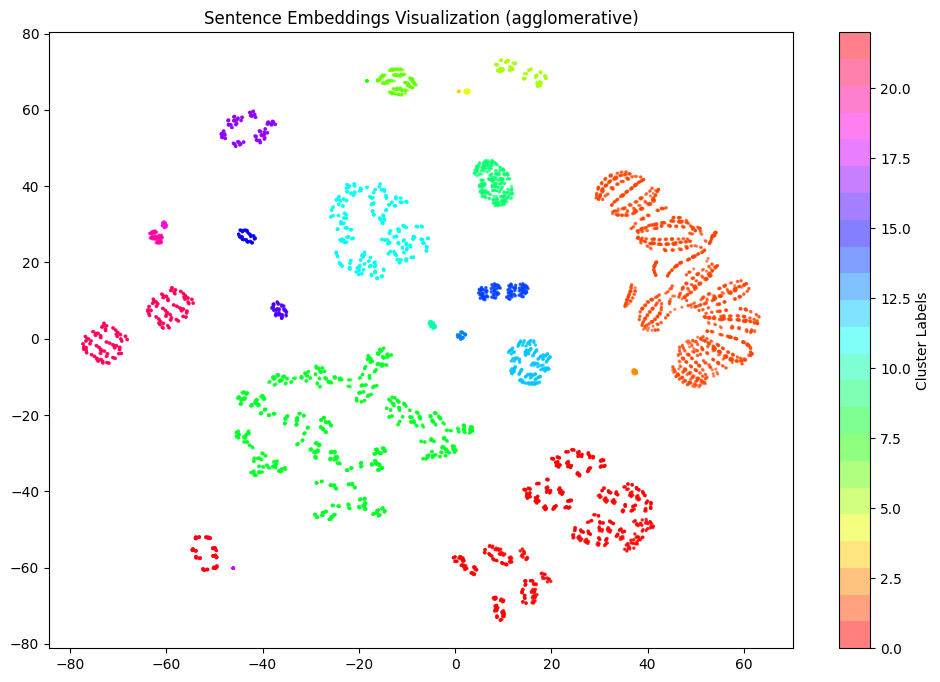

In [10]:
from sklearn.manifold import TSNE

# Clusters visualization using t-SNE
def plot_sentence_embeddings(embeddings, cluster_labels, clustering_method=None):
    plt.figure(figsize=(12, 8))

    reducer = TSNE(n_components=2, random_state=73, metric='cosine', perplexity=60, n_iter=1000)
    embeddings_2d = reducer.fit_transform(np.array(embeddings))

    cluster_labels = np.array(cluster_labels)

    cmap = plt.get_cmap('hsv', len(set(cluster_labels)))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap=cmap, alpha=0.5, s=2)

    plt.colorbar(scatter, label='Cluster Labels')
    plt.title(f"Sentence Embeddings Visualization ({clustering_method})")
    plt.show()

plot_sentence_embeddings(biased_embeddings, cluster_labels=labels, clustering_method=clustering_method)


In [11]:
!pip install subgroups

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.2/282.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 82.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
arviz 0.22.0 requires numpy>=1.26.0, but you have numpy 1.24.4 which is incompatible.
arviz 0.22.0 requires scipy>=1.11.0, but you have scipy 1.10.1 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.3.0 which is in

In [12]:
%%time
run_this = True

if run_this:
    from subgroups.algorithms import BSD
    from subgroups.quality_measures import WRAcc
    from subgroups.quality_measures import WRAccOptimisticEstimate1

    dataset = pd.concat([features_raw, target_df], axis=1)

    for col in dataset.columns:
        dataset[col] = dataset[col].astype(object)

    target = (target_column, target_value)
    #num_subgroups=50!!!!
    bsd_model = BSD(min_support=0, quality_measure=WRAcc(), optimistic_estimate = WRAccOptimisticEstimate1(), num_subgroups=50, max_depth=2, write_results_in_file = True, file_path = "./results_BSD.txt" )
    bsd_model.fit(dataset, target)

CPU times: user 4.14 s, sys: 330 ms, total: 4.47 s
Wall time: 6.48 s


In [13]:
def parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit):
    output_file = "results_BSD_.txt"

    with open(file_path, 'r') as file, open(output_file, 'w') as output:
        for line in file:
            match = re.search(r"(Description: \[.*?\]), Target: (.*?) ; Quality Measure WRAcc = ([\d.-]+) ; tp = (\d+) ; fp = (\d+) ; TP = (\d+) ; FP = (\d+)", line)

            if match:
                description = match.group(1)
                target = match.group(2)
                WRAcc = float(match.group(3))
                tp = int(match.group(4))
                fp = int(match.group(5))
                TP = int(match.group(6))
                FP = int(match.group(7))

                description_text = description[13:-1]
                description_length = description_text.count(',') + 1 if description_text else 1

                quality_score = Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit)

                output_line = f"{description}, Target: {target} ; PIQ = {quality_score:.8f} ; WRAcc = {WRAcc:.8f} ; tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                output.write(output_line)

file_path = "results_BSD.txt"
parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit)

In [14]:
import re
import numpy as np
import pandas as pd

def compute_coverage(filename, quality_measure, k, dataset, print_subgroups=False):
    with open(filename, 'r') as file:
        lines = file.readlines()

    subgroups = []

    for line in lines:
        match = re.search(rf"{quality_measure}\s*=\s*([-+]?\d*\.?\d+|nan)\s*;.*tp\s*=\s*(\d+)\s*;\s*fp\s*=\s*(\d+)", line, re.IGNORECASE)
        wracc_match = re.search(r"WRAcc\s*=\s*([-+]?\d*\.?\d+|nan)", line, re.IGNORECASE)

        if match and wracc_match:
            quality = float(match.group(1)) if match.group(1).lower() != 'nan' else np.nan
            tp = int(match.group(2))
            fp = int(match.group(3))
            wracc = float(wracc_match.group(1)) if wracc_match.group(1).lower() != 'nan' else np.nan

            desc_match = re.search(r"Description: \[(.*?)\]", line)
            if desc_match:
                description = desc_match.group(1).split(", ")
            else:
                description = []

            mask = pd.Series(True, index=dataset.index)
            for condition in description:
                try:
                    feature, value = condition.split(" = ")
                    value = value.strip("'")

                    if feature not in dataset.columns:
                        continue

                    mask &= dataset[feature] == value
                except ValueError:
                    continue

            covered_instances = set(dataset[mask].index)

            if covered_instances:
                subgroups.append((quality, wracc, covered_instances, description, line.strip()))

    subgroups.sort(reverse=True, key=lambda x: (np.nan_to_num(x[0], nan=-np.inf)))

    valid_subgroups = [(piq, wracc, covered_instances, desc, text)
                       for piq, wracc, covered_instances, desc, text in subgroups
                       if not np.isnan(piq)]

    top_k_subgroups = valid_subgroups[:k]

    valid_piq_values = [piq for piq, _, _, _, _ in top_k_subgroups]
    valid_wracc_values = [wracc for _, wracc, _, _, _ in top_k_subgroups]

    num_valid_subgroups = len(top_k_subgroups)

    if num_valid_subgroups > 0:
        average_piq = np.mean(valid_piq_values)
        best_piq = np.max(valid_piq_values)
        worst_piq = np.min(valid_piq_values)

        average_wracc = np.mean(valid_wracc_values)
        best_wracc = np.max(valid_wracc_values)
        worst_wracc = np.min(valid_wracc_values)
    else:
        average_piq = best_piq = worst_piq = np.nan
        average_wracc = best_wracc = worst_wracc = np.nan

    covered_instances = set()
    filtered_instance_coverage = {}

    for _, _, instance_ids, _, _ in top_k_subgroups:
        covered_instances.update(instance_ids)
        for instance in instance_ids:
            filtered_instance_coverage[instance] = filtered_instance_coverage.get(instance, 0) + 1

    coverage = len(covered_instances) / len(dataset) if len(dataset) else 0
    overlapping_instances = sum(1 for count in filtered_instance_coverage.values() if count > 1)
    overlap_ratio = overlapping_instances / len(covered_instances) if covered_instances else 0

    if print_subgroups:
        print("Top-k subgroups:")
        for _, _, _, _, subgroup in top_k_subgroups:
            print(subgroup)

    results = {
        "coverage": coverage,
        "overlap_ratio": overlap_ratio,
        "valid_subgroups": num_valid_subgroups,
        "average_piq": average_piq,
        "best_piq": best_piq,
        "worst_piq": worst_piq,
        "average_wracc": average_wracc,
        "best_wracc": best_wracc,
        "worst_wracc": worst_wracc
    }

    return results

print("SDUEBA model:")
results_SDUEBA = compute_coverage('results_SDUEBA.txt', 'PIQ', n_clusters, features_raw, True)
print(f"Coverage: {results_SDUEBA['coverage']:.4f}, Overlap Ratio: {results_SDUEBA['overlap_ratio']:.4f}")
print(f"Average PIQ: {results_SDUEBA['average_piq']:.4f}, Max PIQ: {results_SDUEBA['best_piq']:.4f}, Min PIQ: {results_SDUEBA['worst_piq']:.4f}")
print(f"Average WRAcc: {results_SDUEBA['average_wracc']:.4f}, Max WRAcc: {results_SDUEBA['best_wracc']:.4f}, Min WRAcc: {results_SDUEBA['worst_wracc']:.4f}")

print("\nBSD model:")
results_BSD = compute_coverage('results_BSD_.txt', 'PIQ', n_clusters, features_raw, True)
print(f"Coverage: {results_BSD['coverage']:.4f}, Overlap Ratio: {results_BSD['overlap_ratio']:.4f}")
print(f"Average PIQ: {results_BSD['average_piq']:.4f}, Max PIQ: {results_BSD['best_piq']:.4f}, Min PIQ: {results_BSD['worst_piq']:.4f}")
print(f"Average WRAcc: {results_BSD['average_wracc']:.4f}, Max WRAcc: {results_BSD['best_wracc']:.4f}, Min WRAcc: {results_BSD['worst_wracc']:.4f}")


SDUEBA model:
Top-k subgroups:
Description: [odor = 'pungent'], Target: edibility = 'poisonous' ; PIQ = 0.51797144 ; WRAcc = 0.01632209 ; tp = 256 ; fp = 0 ; TP = 3916 ; FP = 4208
Description: [odor = 'creosote'], Target: edibility = 'poisonous' ; PIQ = 0.51276311 ; WRAcc = 0.01211848 ; tp = 191 ; fp = 1 ; TP = 3916 ; FP = 4208
Description: [spore-print-color = 'purple'], Target: edibility = 'poisonous' ; PIQ = 0.48202856 ; WRAcc = -0.00284803 ; tp = 0 ; fp = 48 ; TP = 3916 ; FP = 4208
Description: [cap-shape = 'sunken'], Target: edibility = 'poisonous' ; PIQ = 0.48202856 ; WRAcc = -0.00189868 ; tp = 0 ; fp = 32 ; TP = 3916 ; FP = 4208
Description: [stalk-root = 'rooted'], Target: edibility = 'poisonous' ; PIQ = 0.48202856 ; WRAcc = -0.01139211 ; tp = 0 ; fp = 192 ; TP = 3916 ; FP = 4208
Description: [ring-type = 'large'], Target: edibility = 'poisonous' ; PIQ = 0.43849613 ; WRAcc = 0.06995212 ; tp = 1193 ; fp = 103 ; TP = 3916 ; FP = 4208
Description: [gill-color = 'buff'], Target: ed

In [15]:
def export_summary_to_excel_append(results, method_name, filename="mushroom_summary.xlsx"):
    summary_data = {
        "Metric": [
            "Valid Subgroups",
            "PIQ best",
            "PIQ worst",
            "PIQ avg",
            "WRACC best",
            "WRACC worst",
            "WRACC avg",
            "Coverage",
            "Overlap"
        ],
        method_name: [
            results['valid_subgroups'],
            round(results['best_piq'], 4) if not np.isnan(results['best_piq']) else np.nan,
            round(results['worst_piq'], 4) if not np.isnan(results['worst_piq']) else np.nan,
            round(results['average_piq'], 4) if not np.isnan(results['average_piq']) else np.nan,
            round(results['best_wracc'], 4) if not np.isnan(results['best_wracc']) else np.nan,
            round(results['worst_wracc'], 4) if not np.isnan(results['worst_wracc']) else np.nan,
            round(results['average_wracc'], 4) if not np.isnan(results['average_wracc']) else np.nan,
            round(results['coverage'], 4),
            round(results['overlap_ratio'], 4)
        ]
    }

    new_df = pd.DataFrame(summary_data)

    if os.path.exists(filename):
        existing_df = pd.read_excel(filename)

        if 'Metric' not in existing_df.columns:
            existing_df.rename(columns={existing_df.columns[0]: 'Metric'}, inplace=True)

        if method_name in existing_df.columns:
            existing_df = existing_df.drop(columns=[method_name])

        combined_df = pd.merge(existing_df, new_df, on='Metric', how='outer')
    else:
        combined_df = new_df

    combined_df.to_excel(filename, index=False)
    print(f"Appended or updated results in {filename} for {method_name}.")

export_summary_to_excel_append(results_BSD, method_name="BSD", filename="mushroom_summary.xlsx")
export_summary_to_excel_append(results_SDUEBA, method_name="SDUEBA_TSPG", filename="mushroom_summary.xlsx")

Appended or updated results in mushroom_summary.xlsx for BSD.
Appended or updated results in mushroom_summary.xlsx for SDUEBA_TSPG.
